**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
!pip install tensorflow==2.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.5.0


/usr/local/lib/python3.9/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sDzcLKVZBQWeEYT101bEWCltlaFPjiIN
To: /content/C4_W2_Assignment_Image.png
100% 18.5k/18.5k [00:00<00:00, 31.7MB/s]
Expected:


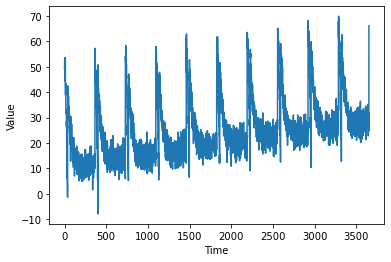

Your output:


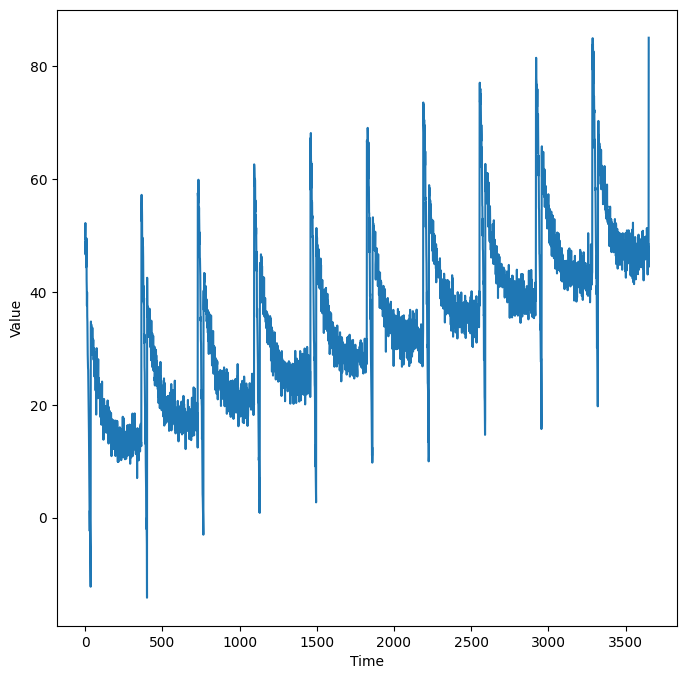

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Просто произвольный шаблон, вы можете изменить его, если хотите"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Повторяет один и тот же шаблон в каждом периоде"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Создадим ряд
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Добавим шум
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

# # # # # expected output
!gdown --id 1sDzcLKVZBQWeEYT101bEWCltlaFPjiIN
print("Expected:")
from IPython.display import display
from PIL import Image
path='./C4_W2_Assignment_Image.png'
display(Image.open(path))
# # # # #

### your output
print("Your output:")
plot_series(time, series)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
dataset
x_train

array([49.418995, 50.16168 , 52.23154 , ..., 52.47819 , 53.385994,
       55.978344], dtype=float32)

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1, activation="relu", input_shape=(window_size,)),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(window_size, activation="relu"),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001, epsilon=1e-5), loss="mean_absolute_error")
model.fit(dataset, epochs=100, verbose=0)

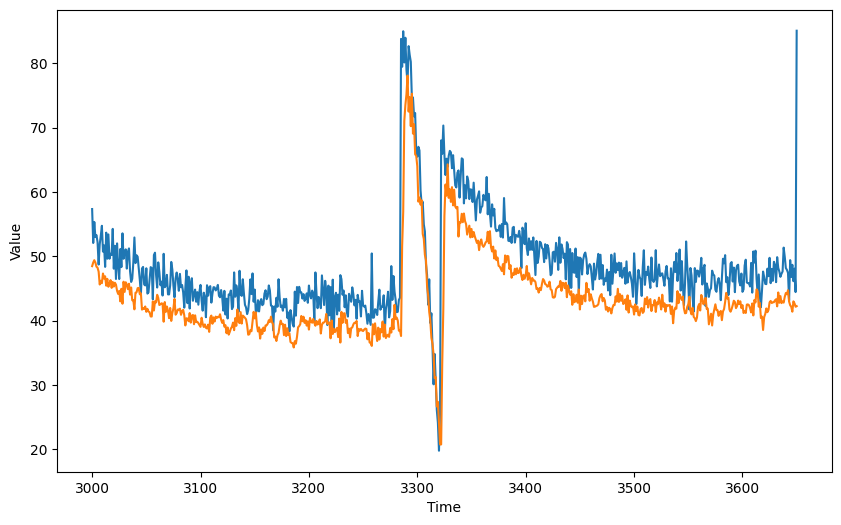

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

4.981907

#Мои данные

In [ ]:
%pylab inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [ ]:
dataframe = pd.read_csv('/content/drive/MyDrive/Учёба/Анализ временных рядов/lr1/covid19_deaths_USA.csv', dayfirst = True, index_col = "Date", parse_dates = ['Date'])
dataframe = dataframe.drop(columns="Unnamed: 0")
dataframe
#df

Deaths
Date              
2023-04-05     632
2023-04-04     312
2023-04-03      33
2023-04-02     225
2023-04-01      29
...            ...
2020-03-15       7
2020-03-14       7
2020-03-13       4
2020-03-12       8
2020-03-11       6

[1121 rows x 1 columns]

Text(0, 0.5, 'Death from COVID-19 in USA')

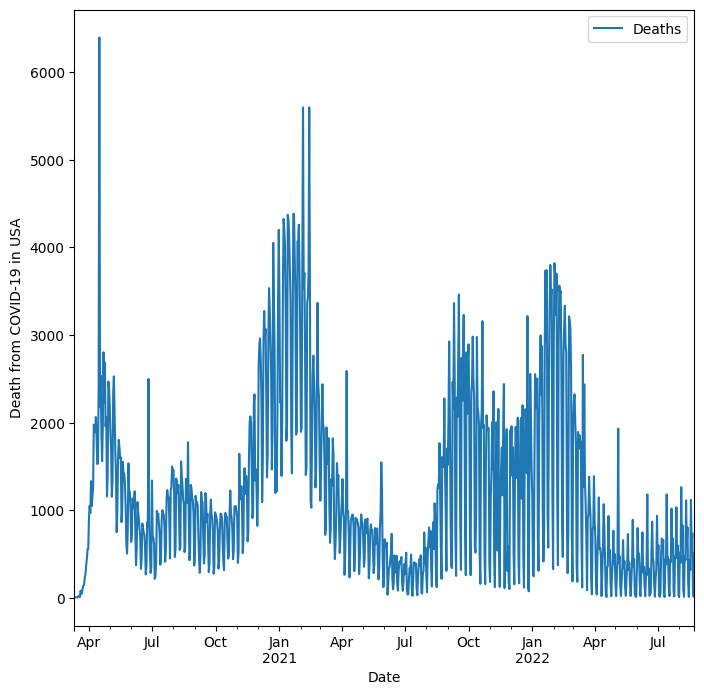

In [ ]:
#df = dataframe[dataframe['Deaths'] > 0]
#df = df['Deaths']
#df = df.dropna(axis=0,how='any')
#df = pd.DataFrame(df)
df = dataframe[::-1]
df_validation = df[int(len(df)*0.8):]
df = pd.DataFrame(df[:int(len(df)*0.8)])
df.plot(figsize(8,8))
plt.ylabel(f'{"Death from COVID-19 in USA"}') 

In [ ]:
#Как избавиться от аномалий: установить порог для максимального значения признака и для минимального . Иначе - приравнять значение к максимальному и минимальному порогу

Q_1 = {} #объявляем словари для минимального и максимального значения
Q_3 = {}
for elem in df.describe().columns:
  Q_1[elem] = df.describe().iloc[4][elem] #записываем в словарь значения первого квартиля
  Q_3[elem] = df.describe().iloc[6][elem] #записываем в словарь значения третьего квартиля
print(Q_1["Deaths"], Q_3["Deaths"])
for index, row in df.iterrows():
  if row["Deaths"] > 2 * Q_3["Deaths"]:
    df.loc[index, "Deaths"] = int(np.random.uniform(0.75 * Q_3["Deaths"], 1.5 * Q_3["Deaths"]))
  #elif row["Deaths"] < 0.5 * Q_1["Deaths"]:
  #  df.loc[index, "Deaths"] = int(np.random.uniform(0.75 * Q_1["Deaths"], 1.5 * Q_1["Deaths"]))


430.75 1719.0


Text(0, 0.5, 'Death from COVID-19 in USA')

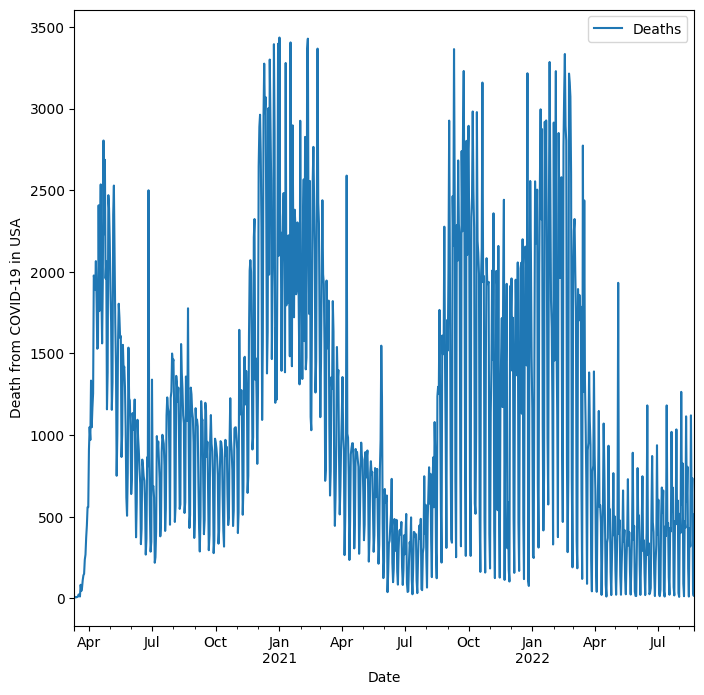

In [ ]:
df.plot(figsize(8,8))
plt.ylabel(f'{"Death from COVID-19 in USA"}') 

In [ ]:
df.index

DatetimeIndex(['2020-03-11', '2020-03-12', '2020-03-13', '2020-03-14',
               '2020-03-15', '2020-03-16', '2020-03-17', '2020-03-18',
               '2020-03-19', '2020-03-20',
               ...
               '2022-08-14', '2022-08-15', '2022-08-16', '2022-08-17',
               '2022-08-18', '2022-08-19', '2022-08-20', '2022-08-21',
               '2022-08-22', '2022-08-23'],
              dtype='datetime64[ns]', name='Date', length=896, freq=None)

In [ ]:
time = df.index
time_series = df['Deaths'].values
split_time = int(len(time_series) * 0.8)
time_train = time[:split_time]
x_train = time_series[:split_time]
time_valid = time[split_time:]
x_valid = time_series[split_time:]

window_size = 20
batch_size = 16
shuffle_buffer_size = 300


In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(1, activation="relu", input_shape=(window_size,)),
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dropout(0.05),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(window_size, activation="relu"),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001, epsilon=1e-5), loss="mean_absolute_error")
model.fit(dataset, epochs=100, verbose=0)

In [ ]:
forecast = []
for elem in range(len(time_series) - window_size):
  forecast.append(model.predict(time_series[elem:elem + window_size][np.newaxis]))

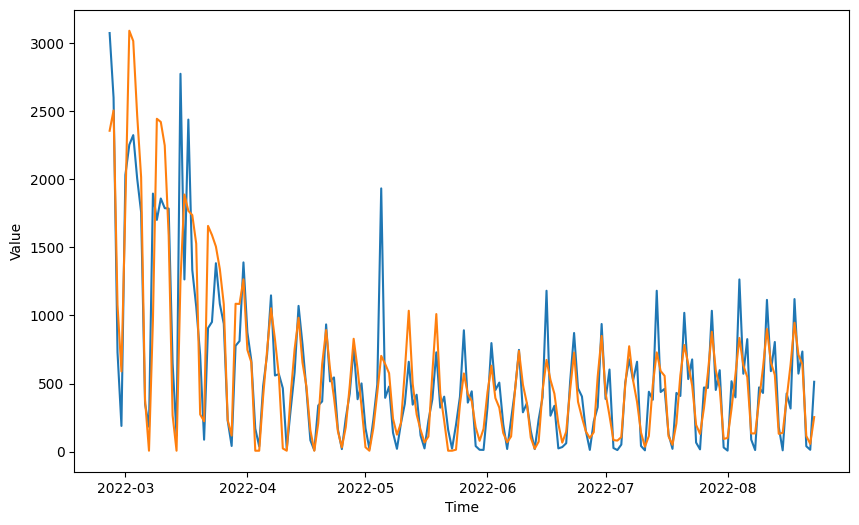

In [ ]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_percentage_error(x_valid, results).numpy()

94.533905

In [ ]:
np.array(forecast).shape

(180, 1, 20)

In [ ]:
pd.DataFrame(x_valid, results)

0
2355.036133  3072
2503.998047  2598
1077.140137   730
588.913818    189
1803.125854  2031
...           ...
711.286865    573
642.005310    735
115.311592     40
57.442654      14
254.118820    513

[180 rows x 1 columns]